# 카트폴 게임 마스터하기

In [ ]:
import gym # 카트폴같은 여러 게임 환경 제공 패키지
# pip install gym 으로 설치 가능#
import random # 에이전트가 무작위로 행동할 확률을 구하기 위함.
import math # 에이전트가 무작위로 행동할 확률을 구하기 위함.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
#Deque : 먼저 들어온 데이터가 먼저 나가는 FIFO 자료구조의 일종으로 double-ended queue의 약자로, 일반적인 큐와 달리 양쪽 끝에서 삽입,삭제가 모두 가능한 자료구조다.
import matplotlib.pyplot as plt
# 필수 모듈 임포트하기

### 하이퍼파라미터



In [ ]:
# 하이퍼파라미터 정의
EPISODES = 50    # 애피소드(총 플레이할 게임 수) 반복횟수
EPS_START = 0.9  # 학습 시작시 에이전트가 무작위로 행동할 확률
# ex) 0.5면 50% 절반의 확률로 무작위 행동, 나머지 절반은 학습된 방향으로 행동
# random하게 EPisolon을 두는 이유는 Agent가 가능한 모든 행동을 경험하기 위함.
EPS_END = 0.05   # 학습 막바지에 에이전트가 무작위로 행동할 확률
#EPS_START에서 END까지 점진적으로 감소시켜줌.
# --> 초반에는 경험을 많이 쌓게 하고, 점차 학습하면서 똑똑해지니깐 학습한대로 진행하게끔
EPS_DECAY = 200  # 학습 진행시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8      # 할인계수 : 에이전트가 현재 reward를 미래 reward보다 얼마나 더 가치있게 여기는지에 대한 값.
# 일종의 할인율
LR = 0.001       # 학습률
BATCH_SIZE = 64  # 배치 크기

##DQN Agent 네트워크


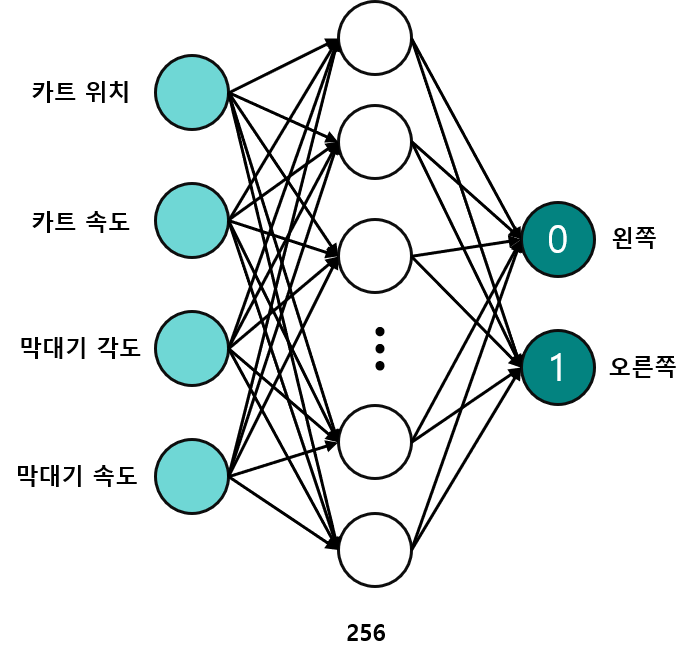

## DQN 에이전트

In [ ]:
class DQNAgent:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(4, 256),#신경망은 카트 위치, 카트 속도, 막대기 각도, 막대기 속도까지 4가지 정보를 입력
            nn.ReLU(),
            nn.Linear(256, 2)#왼쪽으로 갈 때의 가치와 오른쪽으로 갈 때의 가치
        )
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0 #self.steps_done은 학습을 반복할 때마다 증가
        self.memory = deque(maxlen=10000)

    def memorize(self, state, action, reward, next_state):#기억하기
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])))
        # self.memory = [(상태, 행동, 보상, 다음 상태)...]
    
    def act(self, state):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if random.random() > eps_threshold:
            return self.model(state).data.max(1)[1].view(1, 1)
        else:
            return torch.LongTensor([[random.randrange(2)]])
    
    def learn(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        current_q = self.model(states).gather(1, actions)
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (GAMMA * max_next_q)
        
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## 학습 준비하기

`gym`을 이용하여 `CartPole-v0`환경을 준비하고 앞서 만들어둔 DQNAgent를 agent로 인스턴스화 합니다.

자, 이제 `agent` 객체를 이용하여 `CartPole-v0` 환경과 상호작용을 통해 게임을 배우도록 하겠습니다.

In [ ]:
env = gym.make('CartPole-v0')
agent = DQNAgent()
score_history = []

## 학습 시작

In [ ]:
for e in range(1, EPISODES+1):
    state = env.reset()
    steps = 0
    while True:
        env.render()
        state = torch.FloatTensor([state])
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action.item())

        # 게임이 끝났을 경우 마이너스 보상주기
        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1

        if done:
            print("에피소드:{0} 점수: {1}".format(e, steps))
            score_history.append(steps)
            break

에피소드:1 점수: 12
에피소드:2 점수: 19
에피소드:3 점수: 68
에피소드:4 점수: 14
에피소드:5 점수: 12
에피소드:6 점수: 13
에피소드:7 점수: 10
에피소드:8 점수: 13
에피소드:9 점수: 10
에피소드:10 점수: 8
에피소드:11 점수: 12
에피소드:12 점수: 13
에피소드:13 점수: 12
에피소드:14 점수: 14
에피소드:15 점수: 9
에피소드:16 점수: 12
에피소드:17 점수: 10
에피소드:18 점수: 12
에피소드:19 점수: 15
에피소드:20 점수: 11
에피소드:21 점수: 14
에피소드:22 점수: 11
에피소드:23 점수: 11
에피소드:24 점수: 12
에피소드:25 점수: 25
에피소드:26 점수: 28
에피소드:27 점수: 21
에피소드:28 점수: 22
에피소드:29 점수: 24
에피소드:30 점수: 34
에피소드:31 점수: 25
에피소드:32 점수: 34
에피소드:33 점수: 56
에피소드:34 점수: 152
에피소드:35 점수: 136
에피소드:36 점수: 200
에피소드:37 점수: 193
에피소드:38 점수: 189
에피소드:39 점수: 200
에피소드:40 점수: 200
에피소드:41 점수: 200
에피소드:42 점수: 192
에피소드:43 점수: 162
에피소드:44 점수: 200
에피소드:45 점수: 200
에피소드:46 점수: 200
에피소드:47 점수: 200
에피소드:48 점수: 200
에피소드:49 점수: 200
에피소드:50 점수: 200


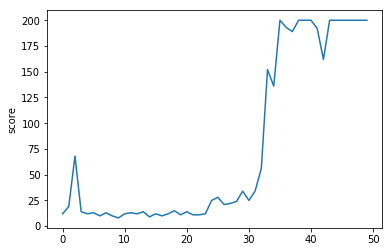

In [ ]:
plt.plot(score_history)
plt.ylabel('score')
plt.show()